# **Toy models of Superposition**: Introductory tutorial

So... let's get started and reveal superposition in practice!

Our tutorial is based on one of the most recognized mechanistic interpretability resources—[ARENA](https://arena-chapter1-transformer-interp.streamlit.app/), authored by Callum McDougall. We selected the first [1.3.1 Toy Models of Superposition & Sparse Autoencoders](https://arena-chapter1-transformer-interp.streamlit.app/[1.3.1]_Toy_Models_of_Superposition_&_SAEs#1-3-1-toy-models-of-superposition-and-sparse-autoencoders) chapter, which is devoted to replicating the first part of [Toy models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html) (TMS) paper mentioned in the presentation.

<details>
<summary>Small note on the ARENA links (skip if you're reading this during the workshop)</summary>
ARENA is constantly updated, so the links above may become outdated in the future. If you found that some of them no longer work, googling "Arena toy models of superposition" should do it.
</details>


<details>
<summary>Reach out here if you have any questions</summary>
Taras Kutsyk — [LinkedIn](https://www.linkedin.com/in/taras-kutsyk-135006212/)
</details>

We also added additional explanations and auxiliary sections to make the tutorial more beginner-friendly🤗. These sections fall into 2 groups:

*   **Theoretical background:** we already provided some context of what a feature is, why we focus on directions instead of individual neurons etc. But don't worry if some of it sounds to you magical just now, there are more explanations/refreshers up next in the tutorial.
*   **Practical background:** how to write efficient and understandable code in mechanistic interpretability (and generally in high-quality ML repositories).

We'll start with the theoretical part.



<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/galaxies.jpeg" width="350">


# Theoretical background


> Timing suggestion: 15min.



### How to define a **feature**?

Unfortunately, there's no single correct answer to this. Many of the definitions are  either too vague or circular. We'll give you a slightly vague, but intuitive one:

A feature is any **property of an input** to the model (or some subset of the input) that is useful for the model's task. In other words, a feature is "anything that you would like to know about your input to produce the correct output". This might be
- Knowing if the given image patch contains snouts (useful for recognizing pets!)
- Knowing if the current word/token is inside a Python function (useful for predicting the correct indentation!)

### What are the **importance** and **sparsity** of features?

**Importance** = how useful is this feature for achieving lower loss (i.e. solving the task better)?

**Sparsity** = how frequently is it in the input data?

You'll see how exactly we will implement these notion shortly. For now, we would just suggest to stop and think for a minute about the sparsity definition.
- Image all possible internet texts that current LLMs are trained on.
- How many of them contain a specific language feature (like the "Code-inside-function" feature from above) you can think of?
- Can you think of a non-trivial feature that would be a common property of more than 10% of all internet tokens (words)? Can you think of many such features, or is it rather an exception?

### Superposition hypothesis: recap

Make sure you understand the definition below (we'll help you with that):

> Superposition is when a model represents **more than n features in an $n$-dimensional activation space**. That is, features still correspond to directions, but the set of interpretable directions (i.e. features, by assumption) is larger than the number of dimensions.

^Rephrased [definition from Neel Nanda's Glossary](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=3br1psLRIjQCOv2T4RN3V6F2)


- **$n$-dimensional activation space**: a set of all possible activations of $n$ neurons in a specific layer (e.g., CNN feature map(s), MLP neurons)
- *"features correspond to directions"*—this is the idea from the presentation, that in practice **only particular combinations of neurons** (i.e. directions in activation space) seem to **correspond to a single interpretable concept**, rather than individual neurons (which are almost always polysemantic).

Why should we expect something like this to happen? In general, the world has way more features than the model has dimensions of freedom (e.g. neurons), and so we can't have a one-to-one mapping between features and values in our model. But the model has to represent these features somehow. Hence, it comes up with techniques for cramming multiple features into fewer dimensions (at the cost of adding noise and interference between features, more on that later).

### Extra
ARENA has a [list of reading materials](https://arena-chapter1-transformer-interp.streamlit.app/[1.3.1]_Toy_Models_of_Superposition_&_SAEs#reading-material) that are recommended to read before the tutorial. You've just read our own minimal summary of it above, but for greater understanding we recommend checking the full list *after* the workshop. It is included in the spoiler block below.

<details>
<summary>Don't read it during the workshop, please :)</summary>

* [200 COP in MI: Exploring Polysemanticity and Superposition](https://www.alignmentforum.org/posts/o6ptPu7arZrqRCxyz/200-cop-in-mi-exploring-polysemanticity-and-superposition), <b>15 mins</b>
    * Read the post, up to and including "Tips" (although some parts of it might make more sense after you've read the other things here).
* Neel Nanda's [Dynalist notes on superposition](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=3br1psLRIjQCOv2T4RN3V6F2), <b>10 mins</b>
    * These aren't long, you should skim through them, and also use them as a reference during these exercises.
    * Checking other sections, for example the [one on feature definitions](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qcCMeIJOryKy3gkDnogQ6X0C) is also a great investment of time.
* Anthropic's [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html), <b>20 mins</b>
    * You should read up to & including the "Summary: A Hierarchy of Feature Properties" section.
    * The first few sections ("Key Results", "Definitions and Motivation", and "Empirical Phenomena" are particularly important).
    * We'll also be going through other parts of this paper as we work through the exercises.
</details>

# Practical background


> Timing suggestion: 20min.

Before we dive into the main content of our tutorial, let's take a moment to learn about a powerful and efficient way of working with data in PyTorch. This approach will not only make your code much faster but also much easier to read and debug.

We'll cover three key ideas:

1.  **Vectorization**: The art of avoiding slow `for`-loops and thinking in terms of whole tensors.
2.  **Einops**: A fantastic library that makes manipulating complex tensors intuitive and safe.
3.  **Type Annotations**: A way to document our code, making tensor shapes explicit.

The 1st **Vectorization** section section is optional if you've ever worked with Pytorch and already know why working with tensors is much more efficient than simply running Python for-loops.

## Introduction to Vectorization and Einops

So let's get started!

In [ ]:
# Setting up the Colab environment
# (please ignore the details below)
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"

if IN_COLAB:
    # Install packages
    %pip install jaxtyping
    %pip install transformer_lens
    %pip install git+https://github.com/callummcdougall/eindex.git

    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists(f"/content/{chapter}"):
        !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/arena_pre_v4.zip
        !unzip /content/arena_pre_v4.zip 'ARENA_3.0-arena_pre_v4/chapter1_transformer_interp/exercises/*'
        sys.path.append(f"/content/{repo}-arena_pre_v4/{chapter}/exercises")
        os.remove("/content/arena_pre_v4.zip")
        os.rename(f"{repo}-arena_pre_v4/{chapter}", chapter)
        os.rmdir(f"{repo}-arena_pre_v4")
        os.chdir(f"{chapter}/exercises")
else:
    raise Exception("If running from VSCode, you should copy code from the Streamlit page, not the Colab.")

  Cloning https://github.com/callummcdougall/eindex.git to /tmp/pip-req-build-hxr9f_hd
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/eindex.git /tmp/pip-req-build-hxr9f_hd
  Resolved https://github.com/callummcdougall/eindex.git to commit 33078c1a5838751b246af19dff13ce3b7bb9103b
  Preparing metadata (setup.py) ... done
  Created wheel for eindex-callum: filename=eindex_callum-0.1.1-py3-none-any.whl size=9192 sha256=80a46b605a56837a0c4323a0bca90155ff2e9a132d1450a8d85ef5bedd1f25ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-gc8uhkhk/wheels/72/5c/9a/915b87a490e2a7c422c35d429ac85365aaccaf5a16c773ac98
Successfully built eindex-callum
--2025-10-14 10:47:20--  https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/arena_pre_v4.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github

In [ ]:
import sys
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Literal
import einops
import numpy as np
import torch
import torch as t
from jaxtyping import Float
from torch import Tensor, nn
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from IPython.display import display, HTML

from einops import rearrange, reduce, einsum
from jaxtyping import Float
from torch import Tensor

# Make sure exercises are in the path
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part31_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

import part31_superposition_and_saes.utils as utils
import part31_superposition_and_saes.tests as tests
from plotly_utils import line, imshow

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"Using device: {device}")

MAIN = __name__ == "__main__"

Using device: cuda


You may need to restart the session here due to the newly installed packages:
> Runtime -> Restart Session -> Run before (after clicking on this cell)

## 0. (Optional) Thinking in Tensors (Vectorization)

> Skip this section if you know why we try to write Pytorch code as transformations of tensors and avoid Python for-loops.

In Python, we often learn to process data by iterating through it with `for`-loops. This is intuitive, but it's also **extremely slow** for numerical computing.

Let's imagine a simple task: we have a large set of numbers, and we want to double each one.

#### The "Slow" Way: Using a `for`-loop

In [ ]:
# Generate A list of N random numbers
N = 100_000

data_list = [t.randn(1) for _ in range(N)]

# Let's time how long it takes to double them with a loop
start_time = time.time()
doubled_list = []
for x in data_list:
    doubled_list.append(x * 2)
end_time = time.time()

print(f"For-loop took: {end_time - start_time:.4f} seconds")

For-loop took: 1.0974 seconds


This works, but it takes a noticeable amount of time. Every single multiplication is a separate operation that Python has to interpret.

#### The "Fast" Way: Vectorization with PyTorch Tensors

Now, let's do the same thing, but with a PyTorch tensor. A tensor is a multi-dimensional array that holds all our data in one contiguous block of memory.

In [ ]:
# A tensor of N random numbers
data_tensor = t.randn(N, device=device)

# Let's time how long it takes to double the whole tensor
start_time = time.time()
doubled_tensor = data_tensor * 2
end_time = time.time()

print(f"Vectorized operation took: {end_time - start_time:.4f} seconds")

Vectorized operation took: 0.0447 seconds


The difference is staggering! The tensor operation is orders of magnitude faster.

**What is happening here?**

This is **vectorization**. Instead of telling Python "take the first number, multiply by two, take the second, multiply by two...", we give a single command: "multiply this entire block of numbers by two".

PyTorch then hands this single, simple command to highly-optimized, low-level code (written in C++ or CUDA for GPUs) which can perform the operation on all the numbers in parallel.

> **The Golden Rule of Efficient Programming in PyTorch:**
>
> Any time you want to write a `for`-loop to transform data, stop and think: "Is there a PyTorch function that can do this for the entire tensor at once?"
>
> The answer is almost always **yes**.

Remember: this applies not only to complex fuctions like selecting a maximum or conditional assignment, but also to elementary operations: `+`, `-`, `*`, `/`, `< | <= | > | >=`, all of which can operate on entire tensors without needing any for-loops (as in the example with `* 2` above).

---

## 1. The Problem: Tensors Have Too Many Dimensions!

Vectorization is powerful, but it comes with its own challenge. We start working with tensors that have many dimensions. For example, a batch of video clips could have a shape like `(batch, time, height, width, channels)`.

This makes common operations surprisingly tricky to write clearly. Imagine a simpler example when we have two batches of *vectors*, and we want to compute the dot product between corresponding vectors in each batch.

In [ ]:
batch_size = 16
dim = 32
x = t.randn(batch_size, dim)
y = t.randn(batch_size, dim)

# The standard PyTorch way for a batched dot product
dot_products_torch = (x * y).sum(dim=1)

print(f"Shape of result: {dot_products_torch.shape}")

Shape of result: torch.Size([16])


This code works, but it has a problem: `(x * y).sum(dim=1)`.

*   **It's not immediately obvious**: You have to mentally parse this as "first, perform element-wise multiplication, then sum along dimension 1." It doesn't scream "batched dot product."
*   **It's fragile**: What if the dimension order changes? For example, some function that you called may modify the tensors in-place by transposing them, so that your "batch" dimension becomes dimension 1. So as a code reader, you always have to keep in mind all of the shapes of your tensors.

We need a better way to tell PyTorch what we *mean*, not just which operations and dimension numbers to use.

## 2. Einops to the Rescue!

`einops` (Einstein Operations) is a small but powerful library that lets us manipulate tensors using a simple, readable string-based notation. It's like speaking the language of tensor shapes directly.

While `einops` has several useful functions, we will focus on its crown jewel: `einsum`.

### The Main Event: `einops.einsum()`

`einsum` (from Einstein Summation) is an incredibly powerful tool for combining tensors. It can perform dot products, matrix multiplications, transpositions, and much more, all with the same clear notation.

Let's re-do our batched dot product example from before using `einops`.

In [ ]:
# The Einops way
dot_products_einops = einsum(
    x, y,
    'batch dim, batch dim -> batch'
)

print(f"Result shape: {dot_products_einops.shape}")

Result shape: torch.Size([16])


Look at how clear that is! Let's break down the magic string: `'batch dim, batch dim -> batch'`.

*   **`batch dim, batch dim`**: On the left of the `->`, we describe the two input tensors, separated by a comma. We give human-readable names to each dimension.
*   **`-> batch`**: On the right, we describe the desired output shape.
*   **The magic**: `einops` sees that the name `dim` appears in both inputs but is **missing** from the output. This is the core rule of `einsum`: dimensions that appear on the left but not the right are **summed over** after the multiplication.

Yes, you still have to remember about the shapes of your tensors to write the correct "magic string", but
- it forces you to self-document the code, making it clear for the reader (and your future self) what exactly you're doing (e.g., preserve the *batch* dimension, not just an arbitrary "zero" dimension").
- if you're wrong and your specified shapes do not match the shapes of your tensors, einops will print you a nice and clear exception.

Takeaway:
> `einsum` lets you express (potentially) complex interactions between tensors in a single, self-documenting line.

## 3. Synergy with Type Annotations

To make our code even more robust and readable, we can combine the `einops` notation with modern Python type annotations. We'll use the `jaxtyping` library, which is designed specifically for this.

Notice how the `einops` string we write is a perfect description of the tensor's shape. We can *also* put that description right into our function signature!

In [ ]:
def batched_dot_product(
    x: Float[Tensor, "batch dim"],
    y: Float[Tensor, "batch dim"]
) -> Float[Tensor, "batch"]:
    """
    Computes the dot product of two batches of vectors.
    x[i] . y[i] for all i in batch.
    """
    # The type hint above IS the einops expression!
    return einsum(x, y, 'batch dim, batch dim -> batch')

# Let's test it
x_test = t.randn(10, 128)
y_test = t.randn(10, 128)
result = batched_dot_product(x_test, y_test)

print(f"Input shape: {x_test.shape}")
print(f"Output shape: {result.shape}")

Input shape: torch.Size([10, 128])
Output shape: torch.Size([10])


Why bother?

1.  **The function signature tells you exactly what shapes to expect**, using the same human-readable names.
2.  **The function body uses `einsum` with the *exact same notation*** to perform the operation.
3.  Your editor and static analysis tools (like Pyright) can read these annotations to catch bugs before you even run your code!

## Summary

*   **Vectorize**: Avoid Python `for`-loops. Use PyTorch's built-in functions to operate on entire tensors for massive speed-ups.
*   **Use `einops.einsum` for Clarity**: Express complex tensor multiplications and summations with a single, readable string. It makes your code self-documenting.
    * [Einops library](https://einops.rocks/) also has a few other utilities, but they are optional for this turorial. We just give a brief summary of them below, but feel free to skip it.
*   **Annotate Shapes**: Combine `einops` notation with type hints (`jaxtyping`) to speak even more explicitly about your tensor shapes.

As we go through the rest of this workshop, you'll see these patterns used everywhere. Understanding and using them will help you write faster, more readable/maintainable ML code.

<details>
<summary><b>Only when you have time left</b>: Other Powerful Einops Functions (`reduce` and `rearrange`)</summary>

While `einsum` is the most versatile function, `einops` also provides helpers for more specific, common tasks. They use the same intuitive string notation.

### `einops.reduce()` - Aggregating with Clarity

`reduce` is for operations like `sum`, `mean`, `max`, etc., that "reduce" one or more dimensions.

Imagine we have a batch of images with shape `(batch, height, width)` and want to find the brightest pixel (max value) in each image.

```python
images = t.randn(10, 64, 64) # 10 grayscale images of 64x64

# The einops way
max_brightness = reduce(
    images,
    'batch height width -> batch',
    'max'
)

print(f"Shape of original tensor: {images.shape}")
print(f"Shape of result: {max_brightness.shape}")
```

The string `'batch height width -> batch'` clearly states our intent: we are reducing the `height` and `width` dimensions away, keeping only the `batch` dimension. This is much clearer than `images.amax(dim=(1, 2))`.

### `einops.rearrange()` - Reshaping Intuitively

`rearrange` is for changing the shape of a tensor (like `view` or `reshape`) and transposing its dimensions (like `permute`).

A common task is to "flatten" a batch of images to feed into a linear layer. We might start with a shape like `(batch, channels, height, width)` and want to get to `(batch, features)`.

```python
color_images = t.randn(64, 3, 28, 28) # A batch of 64 color images

# The einops way
# The parentheses group dimensions to be combined.
flat_images = rearrange(color_images, 'b c h w -> b (c h w)')

print(f"Original shape: {color_images.shape}")
print(f"Rearranged shape: {flat_images.shape}")
```
The notation `b (c h w)` clearly says: "Keep `b` as its own dimension, and combine `c`, `h`, and `w` into a single new dimension." It's far more explicit than `images.view(64, -1)`.

</details>

# 1️⃣ TMS: Superposition in a Nonprivileged Basis

> Timing suggestion: 15min.
(up to the first Exercise `Implement forward`)


<details>
<summary>What is "Nonprivileged"?</summary>

We kept the original name of this section from ARENA, but we won't delve into what "Nonprivileged Basis" means here. TL;DR — it's just one specific setting where superposition occurs that we will analyze today. You can (and encouraged) to later check the next ARENA section, which covers even more interesting case in the section called 2️⃣ *Toy Models of Superposition: Superposition in a **Privileged** Basis*.

But if you're curious about the definition itself, you can find it [here in the TMS paper](https://transformer-circuits.pub/2022/toy_model/index.html#motivation-privileged).
</details>

Now we're fully equipped to tackle the main section of this tutorial. Let’s talk a bit about **what we want to do**. Before describing the idea formally, we'll start with an illustrative analogy. TMS is not an easy paper to wrap your head around, so a tiny bit of motivation won’t hurt us.


## Toy Model: setup motivation


Suppose that
- I speak in a very simple language, which can only express **5 states** about myself (e.g. I’m hungry/angry/sleepy/happy/sad). Assume each state can be expressed with a numerical score—we call this **“a feature”** (so 5 features in total).
- Then, every sentence I speak in this simple language is a **5-dimensional vector**.

We want to train a neural network that *models* how I speak. It can predict my next sentence (similar to what modern LLMs do with tokens), but for simplicity we consider the one that just reconstructs my original sentence (technically it's the same task of outputting a 5-dim vector).

The key plot twist is that
> My recources are limited, so **my model has fewer neurons than features in my language**. We want to know: *what will it do* in that case?

...and you might have guessed that the answer to this is **superposition.**  

What makes this analogy useful is the following connection:
- My simple language -> natural human language (which presumably can also be expressed as a combination of many features).
- My simple neural network -> modern LLMs (which also have far fewer neurons than the language features).

We study the simple case and call it the “toy model” **in the assumption that this analogy holds**, and we get some insight into how LLMs represent natural-language features.

## Toy Model: formal setup

This is where the ARENA tutorial begins, so let's get our hands dirty!
We'll be examining & running experiments on the toy model studied in the [Demonstrating Superposition](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating) section of the TMS paper.


This paper presented a very rudimentary model for **bottleneck superposition** - when you try and represent more than $n$ features in a vector space of dimension $n$. The model is as follows:

* We take a 5-dimensional input $x$
* We map it down into 2D space
* We map it back up into 5D space (using the transpose of the first matrix)
* We add a bias and ReLU

$$
\begin{aligned}
h &= W x \\
x' &= \operatorname{ReLU}(W^T h + b)
\end{aligned}
$$

The main objective of this model is to reconstruct the input $x$, i.e. minimize the error between $x$ and $x'$ (you'll see the specific loss function below). Can you see now how this connects to our motivating analogy above?

### Each input is a combination of features

The input $x$ represents our five features, which you can think of as the "simple language features" from our analogy. That is, $x = (x_1, x_2, ..., x_5)^T$, with each $x_i$ entry uniformly sampled between 0 and 1.

In our setup, each feature has **importance** and **sparsity**. Recall our earlier definitions:

* **Importance** = how useful is this feature for achieving lower loss?
* **Sparsity** = how frequently is it in the input data?

This is realised in our toy model as follows:

* **Importance** = the coefficient on the weighted mean squared error between the input and output, which we use for training the model
    * In other words, our loss function is $L = \sum_x \sum_i I_i (x_i - x_i^\prime)^2$, where $I_i$ is the importance of feature $i$.
* **Sparsity** = the probability of the corresponding element in $x$ being zero
    * In other words, this affects the way our training data is generated (see the method `generate_batch` in the `Module` class below)
    * We often refer to **feature probability** (1 minus sparsity) rather than sparsity

### Feature embeddings
We can think of $W$ (which is a matrix of shape `(2, 5)`) as a grid of "overlap values" between the (5) features and (2) latent dimensions. In other words, if you select a specific column $j$ from this matrix, which we denote as $W_j$, it tells you what is the direction of the feature $j$ in the model's latent space, i.e. the space where input is projected via $h = W x $. You can see it for yourself using this formula if you set the input to represent only one feature, e.g. $x = (1, 0, 0, 0, 0)^T$.

<details>
<summary>Question* - what is the form of $h$ in the general case $x = (x_1, x_2, ..., x_5)^T$?</b>
</summary>

$$
W =
\begin{pmatrix}
t_1 & t_2 & t_3 & t_4 & t_5 \\
b_1 & b_2 & b_3 & b_4 & b_5
\end{pmatrix},
\quad
x =
\begin{pmatrix}
x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5
\end{pmatrix}
$$


$$
\Rightarrow h = Wx =
\begin{pmatrix}
t_1x_1 + \ldots + t_5x_5 \\
b_1x_1 + \ldots + b_5x_5
\end{pmatrix}
=
\begin{pmatrix} t_1 \\ b_1 \end{pmatrix} x_1
+ \ldots +
\begin{pmatrix} t_5 \\ b_5 \end{pmatrix} x_5
:= W_1 x_1 + \ldots + W_5 x_5
$$

</details>

*We recommend answering these questions only if you're comfortable with linear algebra, otherwise it's fine to just check the answer (clicking on the arrow) to save time.

Now notice something interesting. If we rewrite our earlier equation that the model implements in this way
$$
\begin{aligned}
h &= W x \\
x' &= \operatorname{ReLU}(W^T h + b) = \operatorname{ReLU}(W^T W x + b)
\end{aligned}
$$
we can see that our input $x$ can only influence output through the product $W^T W$. This gives us a hint to look at this product more closely.

The values of the 5x5 matrix $W^T W$ are the dot products between the 2D representations of each pair of features, i.e. $ (W^T W)_{ij} = (W_i, W_j)$ for features $i$ and $j$. To make this intuition clearer, imagine each of the columns of $W$ were unit vectors, then $W^T W$ would be a matrix of cosine similarities between the features (with diagonal elements equal to 1, because the similarity of a feature with itself is 1). To see this for yourself:

In [ ]:
t.manual_seed(2)

W = t.randn(2, 5) # generate 2x5 matrix with gaussian entries
W_normed = W / W.norm(dim=0, keepdim=True) # normalize the columns to unit vectors

imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600)

To put it another way - if the columns of $W$ were orthogonal, then $W^T W$ would be the identity. And this is what we would wish, right? Because in that case, assuming the bias is not trained, i.e., $b = 0$:

$$
x' = \operatorname{ReLU}(W^T W x + b) = \operatorname{ReLU}(x) = x
$$
(recall that $x$ has non-negative entries due to uniform sampling in $[0, 1]$).

Unfortunately for our model, this can't actually be the case because $W$ is a 2x5 matrix, but **its columns can be "nearly orthgonal"** in the sense of having pairwise cosine similarities close to 0.

<details>
<summary>
Question - can you prove that $W^T W$ can't be the identity when $W$ is not a square matrix?
</summary>

Proof #1: the rank of a matrix product $AB$ is upper-bounded by the maximum of the two factors $A$ and $B$. In the case of $W^T W$, both matrices have rank at most 2, so the product has rank at most 2.

Proof #2: for any vector $x$, $W^T W x = W^T (Wx)$ is in the span of the columns of $W^T$, which is vector space with rank 2.

</details>

<details>
<summary>
Is it possible to have "nearly orthogonal" columns in practice?
</summary>

Yes, especially when you're working in higher dimensions. Citing the TMS paper:

> **Almost Orthogonal Vectors.** Although it's only possible to have n orthogonal vectors in an n-dimensional space, it's possible to have exp(n) many "almost orthogonal" (<ϵ cosine similarity) vectors in high-dimensional spaces. See the [Johnson-Lindenstrauss](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma) lemma.

</details>


Another nice thing about using two latent dimensions is that we get to visualise our output! We've got a few helper functions for this purpose.


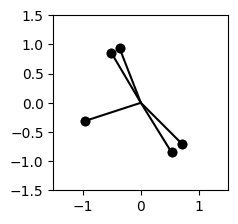

In [ ]:
utils.plot_features_in_2d(
    W_normed.unsqueeze(0), # shape [instances=1 d_hidden=2 features=5]
)

Compare this plot to the `imshow` plot above, and make sure you understand what's going on here (and how the two plots relate to each other). A lot of the subsequent exercises run with this idea of a geometric interpretation of the model's features and latent dimensions.

<details>
<summary>Help - I'm confused about how these plots work.</summary>

As mentioned, you can view $W$ as being a set of five 2D vectors, one for each of our five features. The heatmap shows us the cosine similarities between each pair of these vectors, and the second plot shows us these five vectors in 2D space.

In the example above, we can see two pairs of vectors (the 1st & 2nd, and the 0th & 4th from the heatmap) have very high cosine similarity. This is reflected in the 2D plot, where you can see two pairs of vectors that are very close to each other (one at the top, one at the bottom).

</details>

### Defining our model

Below you can find the code for your model (with most methods not filled out yet).

Some notes on the initialization method, which is filled out for you:

#### Weights & instances

The `Config` class has an `n_inst` field. This is so we can optimize multiple models at once in a single training loop (this'll be useful later on). You should treat this as basically like a batch dimension for your weights: each of your weights/biases will actually be `n_inst` separate weights/biases stacked along the zeroth dimension, and each of these will be trained independently, on different data, in parallel (using the same optimizer).

We initialize weights `W` and `b_final`, which correspond to $W$ and $b$ in the Anthropic paper (and our setup definition).

#### Feature probability and sparsity

The `feature_probability` and `importance` arguments correspond to sparsity and importance of features.

We have the relation  `feature_probability = 1 - sparsity`. We'll usually refer to the feature probability rather than the sparsity, since this is easier. We'll often be dealing with very small values $p = 1 - S \approx 0$. The feature probability is used to generate our training data; the importance is used in our loss function (see later for both of these). The default is `feature_probability = None`, which means $p = 1$ (no sparsity).

The `importance` argument is used when calculating loss (see later exercise). The default is `importance = None` which results in uniform importance.

In the `__init__` method, we have code to broadcast `feature_probability` and `importance`, so that by the end they both always have shape `(n_inst, n_features)`.

### Exercise - implement `forward`

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 20 minutes on this exercise.
```

For now, you just need to fill in the `forward` method. As the exercises go on, you'll fill in some more of these functions, but for now you can ignore the others. And remember about using `einops`!

In [ ]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_inst models in a single training loop to let us sweep over sparsity or importance
    # curves efficiently. You should treat the number of instances `n_inst` like a batch dimension,
    # but one which is built into our training setup. Ignore the latter 3 arguments for now, they'll
    # return in later exercises.
    n_inst: int
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal["unif", "jump"] = "unif"


class Model(nn.Module):
    W: Float[Tensor, "inst d_hidden feats"]
    b_final: Float[Tensor, "inst feats"]

    # Our linear map (for a single instance) is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: float | Tensor = 0.01,
        importance: float | Tensor = 1.0,
        device=device,
    ):
        super(Model, self).__init__()
        self.cfg = cfg

        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to(
            (cfg.n_inst, cfg.n_features)
        )
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        self.W = nn.Parameter(
            nn.init.xavier_normal_(t.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features)))
        )
        self.b_final = nn.Parameter(t.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)


    def forward(
        self,
        features: Float[Tensor, "... inst feats"], # ... denotes the combined batch dimension, i.e. (inst batch) in our case
    ) -> Float[Tensor, "... inst feats"]:
        """
        Performs a single forward pass. For a single instance, this is given by:
            x -> ReLU(W.T @ W @ x + b_final)
        """
        # You'll fill this in later
        raise NotImplementedError()


    def generate_batch(self, batch_size) -> Float[Tensor, "batch inst feats"]:
        """
        Generates a batch of data of shape (batch_size, n_instances, n_features).
        """
        # You'll fill this in later
        raise NotImplementedError()


    def calculate_loss(
        self,
        out: Float[Tensor, "batch inst feats"],
        batch: Float[Tensor, "batch inst feats"],
    ) -> Float[Tensor, ""]:
        """
        Calculates the loss for a given batch (as a scalar tensor), using this loss described in the
        Toy Models of Superposition paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Note, `self.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
        """
        # You'll fill this in later
        raise NotImplementedError()


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_inst, lr=step_lr)


tests.test_model(Model)

NotImplementedError: 

<details>
<summary>Solution</summary>


```python
def forward(
    self,
    features: Float[Tensor, "... inst feats"],
) -> Float[Tensor, "... inst feats"]:
    h = einops.einsum(features, self.W, "... inst feats, inst hidden feats -> ... inst hidden")
    out = einops.einsum(h, self.W, "... inst hidden, inst hidden feats -> ... inst feats")
    return F.relu(out + self.b_final)
```


</details>

### (Optional) Exercise - implement `generate_batch`

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10 minutes on this exercise.
```

Next, you have a choice: you can either implement the function `generate_batch` (going up to the previous cell), OR the next exercise of implementing `calculate_loss` (see below). We recommend implementing `generate_batch` for more advanced participants, i.e., for those who had zero-to-few problems following the tutorial so far.

The `generate_batch` function should return a tensor of shape `(n_batch, instances, features)`, where:

* The `instances` and `features` values are taken from the model config,
* Each feature is present with probability `self.feature_probability`,
* For each present feature, its **magnitude** is sampled from a uniform distribution between 0 and 1.

We recommend looking at the solutions even after you pass the tests, because it might be a bit counter-intuitive how to implement this function efficiently.

Remember, you can assume `model.feature_probability` has shape `(n_inst, n_features)`.

When you've implemented this function and re-run the cell above, run the code below to test it.

In [ ]:
# Go back up and edit your `ToyModel.generate_batch` method, then run the test below

tests.test_generate_batch(Model)

All tests in `test_generate_batch` passed!


<details>
<summary>Solution</summary>


```python
def generate_batch(self, batch_size) -> Float[Tensor, "batch inst feats"]:
    """
    Generates a batch of data.
    """
    batch_shape = (batch_size, self.cfg.n_inst, self.cfg.n_features)
    feat_mag = t.rand(batch_shape, device=self.W.device)
    feat_seeds = t.rand(batch_shape, device=self.W.device)
    return t.where(feat_seeds <= self.feature_probability, feat_mag, 0.0)
```


</details>

## Training our model


The details of training aren't very conceptually important, so we've given you most of the code to train the model in the `Model.optimize` method.

### (Optional) Exercise - implement `calculate_loss`

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10 minutes on this exercise.
```

If you skipped the previous exercise, you should fill in the `calculate_loss` function below. In that case, paste the `generate_batch` code into the model definition from the solution block above.

The loss function **for a single instance** is given by:

$$
L=\frac{1}{BF}\sum_x \sum_i I_i\left(x_i-x_i^{\prime}\right)^2
$$

where:

* $B$ is the batch size,
* $F$ is the number of features,
* $x_i$ are the inputs and $x_i'$ are the model's outputs,
* $I_i$ is the importance of feature $i$,
* $\sum_i$ is a sum over features,
* $\sum_x$ is a sum over the elements in the batch.

For the general case, we sum this formula over all instances.

<details>
<summary>Question - why do you think we take the mean over the feature and batch dimensions, but we sum over the instances dimension?</summary>

We take the mean over batch size because this is standard for loss functions (and means we don't have to use a different learning rate for different batch sizes).

We take the mean over the feature dimension because that's [normal for MSE loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

We sum over the instances dimension because we want to train each instance independently, and at the same rate as we would train a single instance.

</details>

In [ ]:
tests.test_calculate_loss(Model)

All tests in `test_calculate_loss` passed!


<details>
<summary>Solution</summary>

```python
def calculate_loss(
    self,
    out: Float[Tensor, "batch inst feats"],
    batch: Float[Tensor, "batch inst feats"],
) -> Float[Tensor, ""]:
    """
    Calculates the loss for a given batch, using this loss described in the Toy Models paper:

        https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

    Remember, `self.importance` will always have shape (n_inst, n_features).
    """
    error = self.importance * ((batch - out) ** 2)
    loss = einops.reduce(error, "batch inst feats -> inst", "mean").sum()
    return loss
```

</details>

Now, we'll reproduce a version of the figure from the introduction, although with a slightly different version of the code.

A few notes:

* The `importance` argument is the same for all instances. It takes values between 1 and ~0.66 for each feature (so for every instance, there will be some features which are more important than others).
* The `feature_probability` is the same for all features, but it varies across instances. In other words, we're runnning several different experiments at once, and we can compare the effect of having larger feature sparsity in these experiments.


In [ ]:
cfg = Config(n_inst=8, n_features=5, d_hidden=2)

# importance varies within features for each instance
importance = (0.9 ** t.arange(cfg.n_features))

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg.n_inst))

line(importance, width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability, width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [ ]:
model = Model(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

And now once the model is trained, we'll visualize our feature embeddings, i.e. columns of matrix $W$ for each experiment (which is identified by its feature probability value).

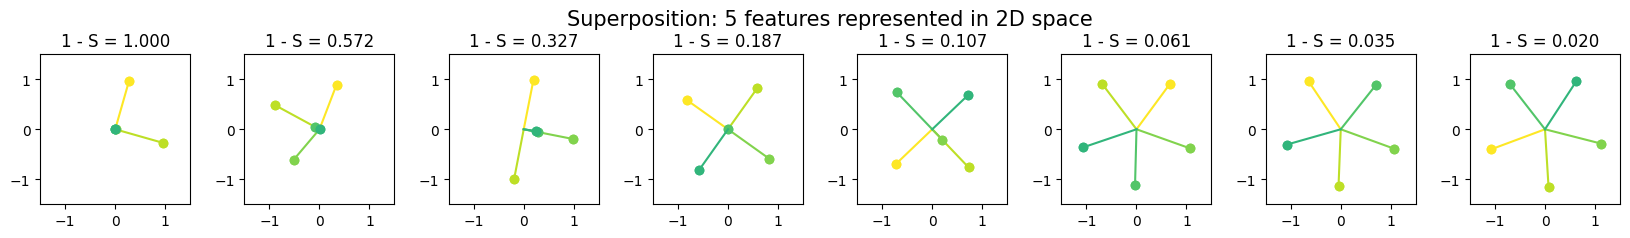

In [ ]:
utils.plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

<details>
<summary>Click this dropdown to see what you should be getting from this visualisation.</summary>

<br>
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/sp1.png" width="1400">

</details>

### So... what is going on?
We'll let *you* answer this question! But before this, it's worth introducing a bit of background and terminology from the TMS paper.

The key idea is that the model tries to embed its features in a way that balances **3 different kinds of interference** between features. We'll define what these kinds of interference are using the following diagram from the TMS paper, which should look quite similar to the feature embeddings that you obtained in the sparse case (when $1-S$ is very small).

<img src="https://raw.githubusercontent.com/TarasKutsyk/TMS_Workshop/refs/heads/main/media/interference.png" width="800">

- **Negative interference**: when two columns of $W$, say $W_i$ and $W_j$, have negative dot products with each other. **RELU makes this kind of interference “free”**, because (intuitively) everything below zero goes to zero and you don't get any loss penalty (see the 2nd spoiler block at the end of this bullet list for a more rigorous explanation).

- **Positive interference**: when two columns of $W$ have positive dot products with each other. This is what is visualized on the left of the above diagram, and can be explained as “**one feature activating looks like a couple of other features activating** (slightly)”. This kind of interference is not free, because the model must learn a negative bias in order to push it below the RELU threshold of zero, essentially transforming it into negative interference. Otherwise, it gets a loss penalty because it “hallucinates” feature activations that weren't there originally.

- **Additive interference**: “**two features activating at the same time look like one feature strongly activating**”—see the right part of the above figure. This is what makes the model prefer orthogonal solutions in the dense case (when all the features are active). Do you see why?
<details>
<summary>Answer</summary>

Because multiple features activating is the “default” case in the dense case, so it wouldn't be possible to assign a meaningful encoding scheme for more than 2 features (because each encoding/embedding would have multiple decodings/reconstructions).
</details>


<details>
<summary>But the model is trained to minimize the reconstruction loss, what does "interference" have to do with that?</summary>

To understand this fully, you should check the [corresponding section](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-math) from the TMS paper. TL;DR—interference can be measured as dot products between different features as we mentioned above, and these dot products actually manifest themselves in a separate loss term when expanded (see below formula). So, the higher the interference, the higher the loss.
<img src="https://raw.githubusercontent.com/TarasKutsyk/TMS_Workshop/refs/heads/main/media/tms_loss_expanded.png" width="700">

The $\operatorname{ReLU}(W_j \cdot W_i + b_j)^2$ term on the right also shows us why the negative interference is free with ReLU: the model doesn't need to learn any bias because $\operatorname{ReLU}(W_j \cdot W_i) = 0$ for all $W_j$ such that $W_j \cdot W_i < 0$.

</details>

### Exercise - interpret these diagrams

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 15 minutes on this exercise (including reading the solutions).
```

Now you should be ready to interpret & analyze those diagrams. Remember that for all diagrams, the features with darker colors have lower importance and the lighter colors have higher importance. Also, the sparsity of all features is increasing as we move from left to right (at the far left there is no sparsity, at the far right feature probability is 5% for all features, i.e. sparsity of 95%).

<details>
<summary>Hint</summary>

For low sparsity, think about what the model would learn to do if all 5 features were present all the time. What's the best our model could do in this case, and how does that relate to the **importance** values?

For high sparsity, think about what the model would learn to do if there was always exactly one feature present. Does this make interference between features less of a problem?
</details>

<details>
<summary>Answer (intuitive)</summary>

When there is no sparsity, the model can never represent more than 2 features faithfully (because of the additive interference), so it makes sense for it to only represent the two most important features. It stores them orthogonally in 2D space, and sets the other 3 features to zero. This way, it can reconstruct these two features perfectly, and ignores all the rest.

For middle sparsity regimes, we now get the benefit from representing more features, but we also get an additive interference because we cannot represent the activation of both features $W_i$ and $W_j$ that lie on the same line, i.e. $W_i = - W_j$ (because their total contribution would be $x_i W_i + x_j W_j = (x_i - x_j) W_i$, so we lose at least one of the features). The model discovers that the trade-off is worth it, because two specific features will be active together only $p^2$ percent of the time, which is negligible for small $p$. The importance of this antipodal structure is discussed more deeply in the [following section of the TMS paper](https://transformer-circuits.pub/2022/toy_model/index.html#geometry).

When there is high sparsity, we get a pentagon structure. Most of the time **at most one of these five features** will be active, which helps avoid interference between features. When we try to recover our initial features by projecting our point in 2D space onto these five directions, most of the time when feature $i$ is present, we can be confident that our projection onto the $i$-th feature direction only captures this feature, rather than being affected by the presence of other features. We omit the mathematical details here.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/download (7).png" width="900">

The key idea here is that two forces are competing in our model: **feature benefit** (representing more thing is good!), and **interference** (representing things non-orthogonally is bad). The higher the sparsity, the more we can reduce the negative impact of interference, and so the trade-off skews towards "represent more features, non-orthogonally".

</details>


We can also generate a batch of inputs and visualise their embeddings.

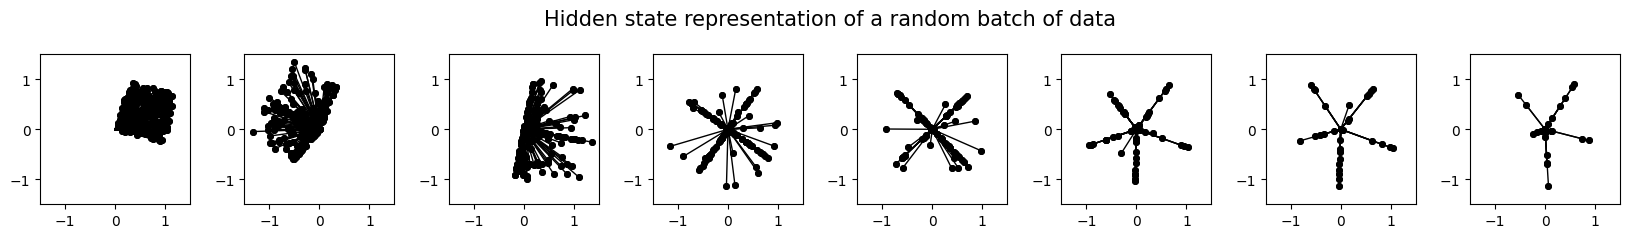

In [ ]:
with t.inference_mode():
    batch = model.generate_batch(200)
    hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")

utils.plot_features_in_2d(hidden, title = "Hidden state representation of a random batch of data")

Most interestingly, you should see that in the plots with high sparsity (to the right), we very rarely have interference between the five features, because most often $\leq 1$ of those features is present, and the model can recover it by projecting along the corresponding feature dimension without losing any information.

<details>
<summary>Click this dropdown to see what you should be getting from this visualisation.</summary>

<br>
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/hs1.png" width="1400">

</details>

## (Optional) Bonus: peaking into high-dimensional spaces


Now that we've got our pentagon plots and started to get geometric intuition for what's going on, let's scale things up! We're now operating in dimensions too large to visualise, but hopefully our intuitions will carry over.


In [ ]:
cfg = Config(n_inst=10, n_features=100, d_hidden=20)

importance = 100 ** -t.linspace(0, 1, cfg.n_features)
feature_probability = 20 ** -t.linspace(0, 1, cfg.n_inst)

line(importance, width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability, width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [ ]:
model = Model(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Because we can't plot features in 2D anymore, we're going to use a different kind of visualisation:

* The **bottom row plots** shows a bar graph of all the features and their corresponding embedding norms $||W_i||$.
    * As we increase sparsity, the model is able to represent more features (i.e. we have more features with embedding norms close to 1).
    * We also color the bars according to whether they're orthogonal to other features (purple) or not (yellow). So we can see that for low sparsity most features are represented orthogonally (like our left-most plots above) but as we increase sparsity we transition to all features being represented non-orthogonally (like our right-most pentagon plots above).
* The **top row plots** show us the dot products between all pairs of feature vectors (kinda like the heatmaps we plotted at the start of this section).
    * This is another way of visualising the increasing interference between features as we increase sparsity.
    * Note that all these right hand plots represent **matrices with rank at most `d_hidden=20`**. The first few are approximately submatrices of the identity (because we perfectly reconstruct 20 features and delete the rest), but the later plots start to display inference as we plot more than 20 values (the diagonals of these matrices have more than 20 non-zero elements).

See the section [Basic Results](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-basic-results) for more of an explanation of this graph and what you should interpret from it.

In [ ]:
utils.plot_features_in_Nd(
    model.W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 80, d_hidden = 20, I<sub>i</sub> = 0.9<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probability],
)